In [124]:
from pathlib import Path
import pandas as pd
from datetime import datetime
from dateutil import relativedelta

gamma_path = Path('/home/engaclew/neurogen/results/conf/conf_file_level.csv')
children_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')

gamma = pd.read_csv(gamma_path)
children = pd.read_csv(children_path)
recordings = pd.read_csv(recordings_path)

data = gamma.merge(recordings, left_on='recording_filename', right_on='recording_filename')
data = data.merge(children, left_on='child_id', right_on='child_id', how='right')

# Compute age at time of recording
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month

data['age'] = data.apply(lambda row: diff_month(row), axis=1)
print(data.groupby('group_id').count())
# excluding them because we have only 2 recordings for these groups
data = data[~data['group_id'].isin(['environmental_risk', 'autism_spectrum_disorder'])]

cols = data.columns
cols = [c for c in cols if c.startswith('vtc_')]
data_vtc_norm = data.copy(deep=True)
data_lena_norm = data.copy(deep=True)

for col in cols:
    # Normalize according to columns: reads "For N% of frames classified as K1 by vtc, LENA says K2"
    spk_vtc = col.split('_')[1]
    data_vtc_norm[col] = 100*data_vtc_norm[col] / data[f'nb_frames_vtc_{spk_vtc}']
    # Normalize according to rows: reads "For N% of frames classified as K1 by LENA, VTC says K2
    spk_lena = col.split('_')[3]
    data_lena_norm[col] = 100*data_lena_norm[col] / data[f'nb_frames_lena_{spk_lena}']

data_vtc_norm['mean_agreement_spkr'] = (data_vtc_norm['vtc_CHI_lena_CHI'] + data_vtc_norm['vtc_OCH_lena_OCH'] + data_vtc_norm['vtc_MAL_lena_MAL'] + data_vtc_norm['vtc_FEM_lena_FEM'])/4
data_lena_norm['mean_agreement_spkr'] = (data_lena_norm['vtc_CHI_lena_CHI'] + data_lena_norm['vtc_OCH_lena_OCH'] + data_lena_norm['vtc_MAL_lena_MAL'] + data_lena_norm['vtc_FEM_lena_FEM'])/4

                          recording_filename  vtc_CHI_lena_CHI  \
group_id                                                         
angelman_syndrome                         92                92   
autism_sibling                            24                24   
autism_spectrum_disorder                   2                 2   
down_syndrome                            101               101   
environmental_risk                         2                 2   
fragile_x_syndrome                        44                44   
low_risk                                 116               116   

                          vtc_CHI_lena_OCH  vtc_CHI_lena_MAL  \
group_id                                                       
angelman_syndrome                       92                92   
autism_sibling                          24                24   
autism_spectrum_disorder                 2                 2   
down_syndrome                          101               101   
environmental_risk   

In [97]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None, offset=0, alpha=1):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh
    barx = [lx+offset, lx+offset, rx-offset, rx-offset]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
    plt.plot(barx, bary, c='black', alpha=alpha)

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
    plt.text(*mid, text, **kwargs, alpha=alpha)

/tmp/ipykernel_38774/2496525316.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(group_label.values()))


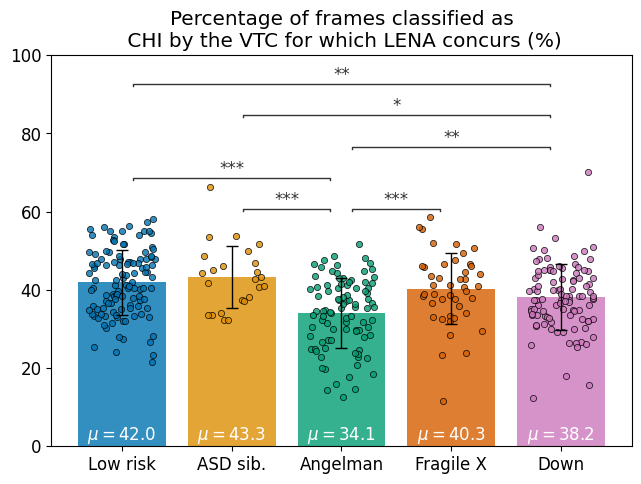

In [114]:
# Analyzing data_vtc_norm: "For N% of frames classified as K1 by vtc, LENA says K2"
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy.stats as stats
from itertools import combinations

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 12, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1})
cm = 1/2.54

# Sorting data by group
group_label = {
    'low_risk': 'Low risk',
    'autism_sibling': 'ASD sib.',
    #'environmental_risk': 'Env. risks',
    'angelman_syndrome': 'Angelman',
    'fragile_x_syndrome': 'Fragile X',
    'down_syndrome': 'Down',
    #'autism_spectrum_disorder': 'ASD'
}
y_label = {
    'mean_agreement_spkr': 'Average percentage of frames classified as\n CHI/OCH/MAL/FEM by the VTC for which LENA concurs (%)',
    'vtc_CHI_lena_CHI': 'Percentage of frames classified as\n CHI by the VTC for which LENA concurs (%)',
}

sorter_index = dict(zip(list(group_label.keys()), range(len(group_label))))
data_vtc_norm['group_rank'] = data_vtc_norm['group_id'].map(sorter_index)
data_vtc_norm.sort_values(by='group_rank', inplace=True)

colors = sns.color_palette('colorblind')[:len(group_label)]
Y_col = 'vtc_CHI_lena_CHI'
X_col = 'group_id'

fig, ax = plt.subplots(1,1, figsize=(16*cm,12*cm), constrained_layout=True)
X = data_vtc_norm[X_col].unique()
Y = data_vtc_norm.groupby(X_col)[Y_col].mean()[X]
Yerr = data_vtc_norm.groupby(X_col)[Y_col].std(ddof=0)[X]
ax.bar(x=X, height=Y, yerr=Yerr, color=colors, capsize=4, linewidth=2, alpha=.8)
ax.set_xticklabels(list(group_label.values()))
ax.set_title(y_label[Y_col])

# plot scatter
for idx, group_id in enumerate(group_label.keys()):
    sub_data = data_vtc_norm[data_vtc_norm['group_id'] == group_id]
    X = idx + np.random.uniform(-0.3, 0.3, size=len(sub_data))
    Y = sub_data[Y_col]
    plt.scatter(X,Y, color=colors[idx], edgecolor='black', linewidth=.6, s=20, alpha=.8)

# Welch's t-Test to compare the means of two different groups 
# (assume different variances compared to standard t-Test)
plt.ylim(0, 100)
X = data_vtc_norm[X_col].unique()
bars = np.arange(len(X))
heights = data_vtc_norm.groupby(X_col)[Y_col].mean()[X].values
grouped_data = data_vtc_norm.groupby('group_id')[Y_col].apply(lambda x:x.values)

combinations = [
    # dist = 1
    ('low_risk', 'autism_sibling'), ('autism_sibling', 'angelman_syndrome'), 
    ('angelman_syndrome', 'fragile_x_syndrome'), ('fragile_x_syndrome', 'down_syndrome'),
    # dist = 2
    ('low_risk', 'angelman_syndrome'), ('autism_sibling', 'fragile_x_syndrome'), ('angelman_syndrome', 'down_syndrome'), 
    # dist = 3
    ('low_risk', 'fragile_x_syndrome'), ('autism_sibling', 'down_syndrome'),
    # dist = 4
    ('low_risk', 'down_syndrome')]
cnt_offset = 0
y_offset = 8.0
for group1, group2 in combinations:
    res = stats.ttest_ind(grouped_data[group1], grouped_data[group2], equal_var=False)
    idx1, idx2 = np.where(X == group1)[0], np.where(X == group2)[0]
    max_y = data_vtc_norm[Y_col].max()-15
    if np.abs(idx1-idx2) == 1 and res.pvalue < .05:
        heights_2 = np.asarray([max_y]*len(X))
        barplot_annotate_brackets(idx1, idx2, res.pvalue, bars, heights_2, dh=.05, barh=0.005, maxasterix=3, offset=.1, alpha=.8)
    elif np.abs(idx1-idx2) > 1 and res.pvalue < .05: 
        cnt_offset += y_offset
        heights_2 = np.asarray([max_y]*len(X)) + cnt_offset
        barplot_annotate_brackets(idx1, idx2, res.pvalue, bars, heights_2, dh=.05, barh=0.005, maxasterix=3, offset=.1, alpha=.8)

# Add mean
for idx, height in enumerate(heights):
    plt.text(x=idx, y=0, s='$\mu=%.1f$' % height, color='white', horizontalalignment='center', verticalalignment='bottom')
plt.savefig(Path('../results/conf_agreement') / f'conf_vtc_norm_{Y_col}_per_{X_col}.png', dpi=300)
plt.show()


/tmp/ipykernel_38774/2265793954.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(group_label.values()))


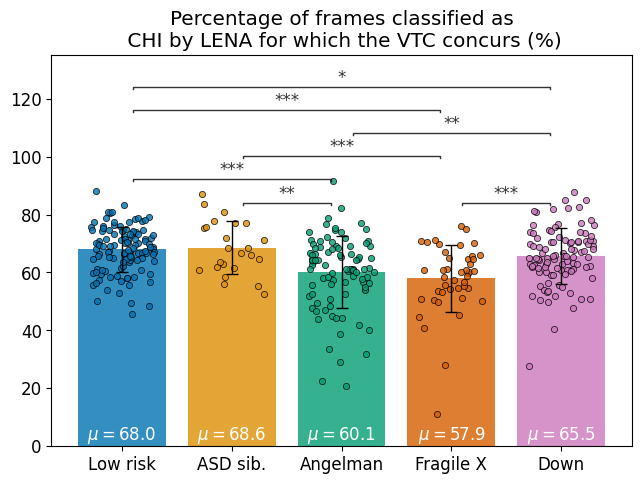

In [123]:
# Analyzing data_lena_norm: "For N% of frames classified as K1 by LENA, VTC says K2"
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy.stats as stats
from itertools import combinations

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 12, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1})
cm = 1/2.54

# Sorting data by group
group_label = {
    'low_risk': 'Low risk',
    'autism_sibling': 'ASD sib.',
    #'environmental_risk': 'Env. risks',
    'angelman_syndrome': 'Angelman',
    'fragile_x_syndrome': 'Fragile X',
    'down_syndrome': 'Down',
    #'autism_spectrum_disorder': 'ASD'
}
y_label = {
    'mean_agreement_spkr': 'Average percentage of frames classified as\n CHI/OCH/MAL/FEM by LENA for which the VTC concurs (%)',
    'vtc_CHI_lena_CHI': 'Percentage of frames classified as\n CHI by LENA for which the VTC concurs (%)',
}

sorter_index = dict(zip(list(group_label.keys()), range(len(group_label))))
data_lena_norm['group_rank'] = data_lena_norm['group_id'].map(sorter_index)
data_lena_norm.sort_values(by='group_rank', inplace=True)

colors = sns.color_palette('colorblind')[:len(group_label)]
Y_col = 'vtc_CHI_lena_CHI'
X_col = 'group_id'

fig, ax = plt.subplots(1,1, figsize=(16*cm,12*cm), constrained_layout=True)
X = data_lena_norm[X_col].unique()
Y = data_lena_norm.groupby(X_col)[Y_col].mean()[X]
Yerr = data_lena_norm.groupby(X_col)[Y_col].std(ddof=0)[X]
ax.bar(x=X, height=Y, yerr=Yerr, color=colors, capsize=4, linewidth=2, alpha=.8)
ax.set_xticklabels(list(group_label.values()))
ax.set_title(y_label[Y_col])

# plot scatter
for idx, group_id in enumerate(group_label.keys()):
    sub_data = data_lena_norm[data_lena_norm['group_id'] == group_id]
    X = idx + np.random.uniform(-0.3, 0.3, size=len(sub_data))
    Y = sub_data[Y_col]
    plt.scatter(X,Y, color=colors[idx], edgecolor='black', linewidth=.6, s=20, alpha=.8)

# Welch's t-Test to compare the means of two different groups 
# (assume different variances compared to standard t-Test)
plt.ylim(0, 135)
X = data_lena_norm[X_col].unique()
bars = np.arange(len(X))
heights = data_lena_norm.groupby(X_col)[Y_col].mean()[X].values
grouped_data = data_lena_norm.groupby('group_id')[Y_col].apply(lambda x:x.values)

combinations = [
    # dist = 1
    ('low_risk', 'autism_sibling'), ('autism_sibling', 'angelman_syndrome'), 
    ('angelman_syndrome', 'fragile_x_syndrome'), ('fragile_x_syndrome', 'down_syndrome'),
    # dist = 2
    ('low_risk', 'angelman_syndrome'), ('autism_sibling', 'fragile_x_syndrome'), ('angelman_syndrome', 'down_syndrome'), 
    # dist = 3
    ('low_risk', 'fragile_x_syndrome'), ('autism_sibling', 'down_syndrome'),
    # dist = 4
    ('low_risk', 'down_syndrome')]
cnt_offset = 0
y_offset = 8.0
for group1, group2 in combinations:
    res = stats.ttest_ind(grouped_data[group1], grouped_data[group2], equal_var=False)
    idx1, idx2 = np.where(X == group1)[0], np.where(X == group2)[0]
    max_y = data_lena_norm[Y_col].max() - 15
    if np.abs(idx1-idx2) == 1 and res.pvalue < .05:
        heights_2 = np.asarray([max_y]*len(X))
        barplot_annotate_brackets(idx1, idx2, res.pvalue, bars, heights_2, dh=.05, barh=0.005, maxasterix=3, offset=.1, alpha=.8)
    elif np.abs(idx1-idx2) > 1 and res.pvalue < .05: 
        cnt_offset += y_offset
        heights_2 = np.asarray([max_y]*len(X)) + cnt_offset
        barplot_annotate_brackets(idx1, idx2, res.pvalue, bars, heights_2, dh=.05, barh=0.005, maxasterix=3, offset=.1, alpha=.8)

# Add mean
for idx, height in enumerate(heights):
    plt.text(x=idx, y=0, s='$\mu=%.1f$' % height, color='white', horizontalalignment='center', verticalalignment='bottom')
plt.savefig(Path('../results/conf_agreement') / f'conf_lena_norm_{Y_col}_per_{X_col}.png', dpi=300)
plt.show()


SignificanceResult(statistic=0.27569366992813094, pvalue=5.2973462131925324e-08)
0.27569366992813094


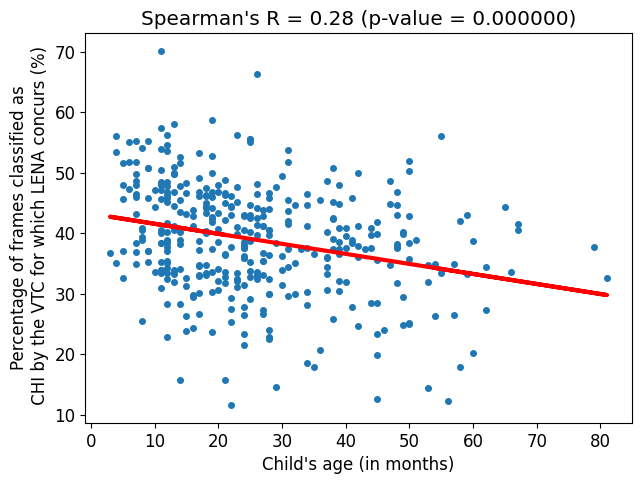

In [178]:
# Analyzing data_vtc_norm: Y ~ recording duration/age
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

fig, ax = plt.subplots(1,1, figsize=(16*cm,12*cm), constrained_layout=True)

y_label = {
    'mean_agreement_spkr': 'Average percentage of frames classified as\n CHI/OCH/MAL/FEM by the VTC for which LENA concurs (%)',
    'vtc_CHI_lena_CHI': 'Percentage of frames classified as\n CHI by the VTC for which LENA concurs (%)',
}

Y_col = 'vtc_CHI_lena_CHI'
X_col = 'age'

if X_col == 'duration':
    X = data_vtc_norm[X_col]/3600000
elif X_col == 'age':
    X = data_vtc_norm[X_col]
Y = data_vtc_norm[Y_col]
X = X.values.reshape(-1, 1)
Y = Y.values
reg = linear_model.LinearRegression()
reg.fit(X, Y)
Y_pred = reg.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red', linewidth=3)
plt.ylabel(y_label[Y_col])

score = spearmanr(Y, Y_pred)
print(score)
print(score.statistic)
plt.title("Spearman's R = %.2f (p-value = %f)" % (score.statistic, score.pvalue))

if X_col == "duration":
    plt.xlabel('Recording duration (h)')
    plt.xlim(0,17)
elif X_col == "age":
    plt.xlabel("Child's age (in months)")
plt.savefig(Path('../results/conf_agreement') / f'conf_vtc_norm_{Y_col}_per_{X_col}.png', dpi=300)
plt.show()

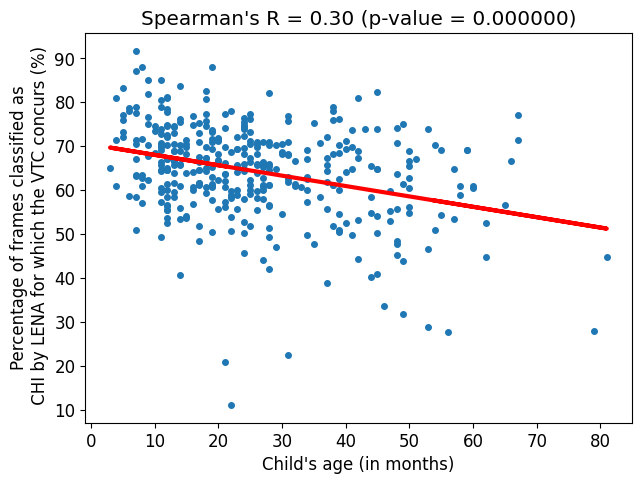

In [186]:
# Analyzing data_lena_norm: Y ~ recording duration/age
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

fig, ax = plt.subplots(1,1, figsize=(16*cm,12*cm), constrained_layout=True)

y_label = {
    'mean_agreement_spkr': 'Average percentage of frames classified as\n CHI/OCH/MAL/FEM by LENA for which the VTC concurs (%)',
    'vtc_CHI_lena_CHI': 'Percentage of frames classified as\n CHI by LENA for which the VTC concurs (%)',
}

Y_col = 'vtc_CHI_lena_CHI'
X_col = 'age'

data_lena_norm = data_lena_norm[~data_lena_norm[Y_col].isna()]
if X_col == 'duration':
    X = data_lena_norm[X_col]/3600000
elif X_col == 'age':
    X = data_lena_norm[X_col]
Y = data_lena_norm[Y_col]
X = X.values.reshape(-1, 1)
Y = Y.values
reg = linear_model.LinearRegression()
reg.fit(X, Y)
Y_pred = reg.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red', linewidth=3)
plt.ylabel(y_label[Y_col])

score = spearmanr(Y, Y_pred)
plt.title("Spearman's R = %.2f (p-value = %f)" % (score.statistic, score.pvalue))

if X_col == "duration":
    plt.xlabel('Recording duration (h)')
    plt.xlim(0,17)
elif X_col == "age":
    plt.xlabel("Child's age (in months)")
plt.savefig(Path('../results/conf_agreement') / f'conf_lena_norm_{Y_col}_per_{X_col}.png', dpi=300)
plt.show()

In [181]:
Y

array([62.22180469, 51.23559371, 56.74756365, 54.49528013, 46.72578883,
       54.33176957, 47.94931435, 58.93831012, 48.97771275, 58.30089943,
       54.05686545, 53.43201548, 60.52043207, 47.51361883, 61.95673462,
       49.889011  , 60.31622126, 53.80110072, 60.29023583, 54.50627781,
       62.03482977, 57.86698344, 59.13845902, 58.71385878, 61.93347075,
       60.40147104, 60.38860376, 53.51038962, 59.26414401, 57.18552567,
       59.63908001, 57.73211432, 62.34829423, 63.20038656, 60.35906868,
       58.80773757, 54.83282478, 46.02864301, 58.65084409, 53.67475003,
       51.27577731, 61.56732675, 57.31314534, 53.73205644, 64.94873659,
       53.33747853, 55.17465735, 54.25116233, 53.30221125, 60.46751038,
       63.03874609, 58.50783837, 44.73292562, 58.21761101, 68.44289471,
       60.22419272, 52.51183895, 55.78661742, 59.54013833, 57.89550915,
       56.48868001, 61.52522781, 50.41207682, 58.52959692, 61.46522701,
       49.81463748, 65.28413016, 58.37657167, 63.06214253, 55.59

,recording_filename,vtc_CHI_lena_CHI,vtc_CHI_lena_OCH,vtc_CHI_lena_MAL,vtc_CHI_lena_FEM,vtc_CHI_lena_SIL,vtc_OCH_lena_CHI,vtc_OCH_lena_OCH,vtc_OCH_lena_MAL,vtc_OCH_lena_FEM,...,start_time,recording_device_type,duration,its_filename,experiment_y,child_dob,child_sex,group_id,age,mean_agreement_spkr
0,20181207_134922_025481.wav,34.824886,10.625548,0.893236,5.998247,47.658083,2.864011,26.905679,0.423915,2.344457,...,5:35:53,lena,57600000,20181207_134922_025481.its,neurogen,2014-06-27,m,angelman_syndrome,54,32.424888
1,20200212_135855_024882_1.wav,41.498588,5.177491,6.042759,7.890278,39.390883,8.829886,15.673562,1.332716,3.174848,...,5:23:28,lena,57600000,20200212_135855_024882_1.its,neurogen,2014-06-27,m,angelman_syndrome,67,30.212493
2,20200212_135855_024882_2.wav,40.560104,3.456618,4.054656,7.644816,44.283807,7.903865,14.866204,0.778706,4.661617,...,6:11:43,lena,57600000,20200212_135855_024882_2.its,neurogen,2014-06-27,m,angelman_syndrome,67,29.137368
3,20181206_151905_022874.wav,35.739237,3.245392,0.545612,3.401757,57.068002,12.298348,12.351286,0.824719,2.783428,...,7:36:24,lena,44707562,20181206_151905_022874.its,neurogen,2014-10-29,m,angelman_syndrome,50,23.169279
4,20200710_084537_024878.wav,41.986470,12.803566,0.286810,5.483680,39.439474,16.425224,16.233490,0.461582,1.999006,...,9:10:55,lena,40335062,20200710_084537_024878.its,neurogen,2015-09-02,f,angelman_syndrome,58,23.794610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,20230214_105958_043300_2.wav,32.406930,20.065484,0.500155,3.369599,43.657832,6.458299,38.156397,0.657075,2.192055,...,8:18:24,lena,44817875,20230214_105958_043300_2.its,neurogen,2022-02-10,m,autism_sibling,12,30.590587
373,20230405_090552_045738_2.wav,43.260791,11.447842,0.958633,5.037770,39.294964,20.202375,23.648226,0.769652,3.574777,...,6:07:35,lena,49690250,20230405_090552_045738_2.its,neurogen,2021-07-13,m,autism_sibling,20,35.417564
374,20230321_124603_024879_1.wav,49.995610,8.382357,0.921942,4.797026,35.903064,16.582670,18.897501,0.576970,4.775642,...,7:58:52,lena,57600000,20230321_124603_024879_1.its,neurogen,2021-08-17,f,autism_sibling,19,31.795691
375,20230328_105824_025480_2.wav,48.738664,15.202780,0.287713,2.722920,33.047922,9.685606,33.035508,0.178276,2.168670,...,10:16:35,lena,57600000,20230328_105824_025480_2.its,neurogen,2021-06-24,f,autism_sibling,21,32.837007
